In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import bokeh as bk
from calendar import day_name
from IPython.display import display, Markdown, HTML
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.tile_providers import get_provider, Vendors
from pyproj import Proj, transform
%matplotlib inline

# Analysis of stations : Visualise missing data and sample data

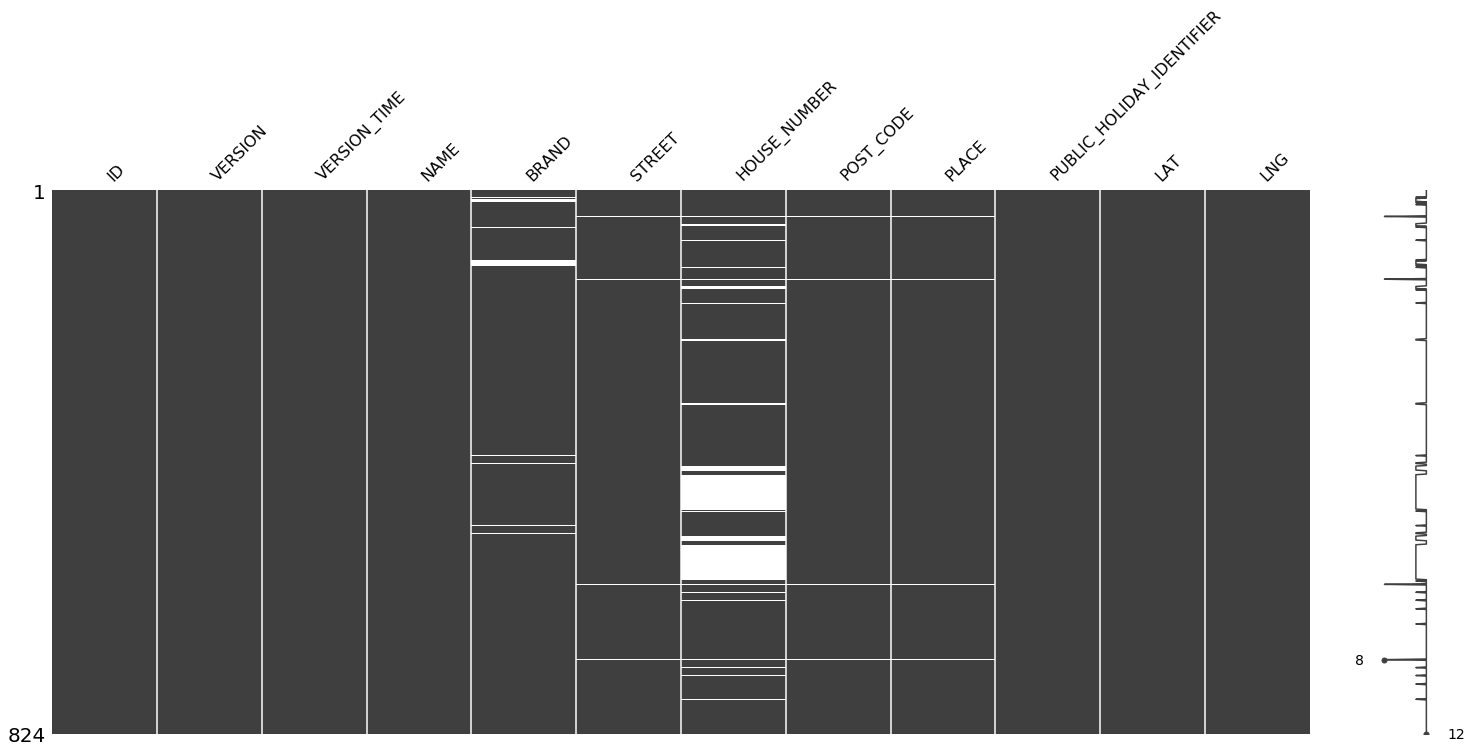

In [2]:
df_stations = pd.read_csv('exercise_data/example_sprit_cut_station.csv',sep=';')

# Visualise number of missing entries
msno.matrix(df_stations);

In [3]:
df_stations.sample(10)

,ID,VERSION,VERSION_TIME,NAME,BRAND,STREET,HOUSE_NUMBER,POST_CODE,PLACE,PUBLIC_HOLIDAY_IDENTIFIER,LAT,LNG
773,6f2391a3-1c74-46b5-bdf0-e00467eca0ab,1,2013-07-25 14:24:31.000000,Aral Tankstelle,ARAL,Landauer Straße,11,76877,Offenbach,\N,49.194378,8.187527
738,dbb0a607-7b91-42bf-af87-0c06c45991ed,1,2013-08-07 02:01:16.000000,Total KAISERSLAUTERN,Total,MAINZER STR.,140,67657,KAISERSLAUTERN,\N,49.457300,7.801527
564,9aab1ae8-c032-4834-bee4-bb0227ec4e3f,1,2013-07-31 22:00:00.000000,EISENBERG ALFRED- NOBEL- ST.,Shell,ALFRED-NOBEL-STR. 2 A,NaN,67304,EISENBERG,\N,49.563500,8.082050
132,8ca3988e-fac2-4f2e-a748-d3b250cd7f71,232,2015-02-01 12:32:25.000000,Regie-Tankstelle Schifferstadt,AVIA,Speyerer Str.,\N,67105,Schifferstadt,\N,49.377100,8.374910
528,3ebc84b4-42be-4f65-a6bd-cc1d38e71513,1,2013-07-31 22:00:00.000000,Ludwigshafen Oppauer Straße 108,SB,Oppauer Straße 108,NaN,67069,Ludwigshafen,\N,49.533873,8.388695
61,42ba4c08-7be7-4460-9c9d-0602b762d862,5,2014-11-02 12:33:21.000000,AVIA Karlsruhe-Waldstadt,AVIA,Königsberger Str.,5,76139,Karlsruhe,\N,49.033400,8.432300
474,09839b72-1976-4e20-b617-acccecf75ea0,1,2013-07-31 22:00:00.000000,LUDWIGSHAFEN STERNSTR.101.,Shell,STERNSTR. 101,NaN,67063,LUDWIGSHAFEN FRIESENHEIM,\N,49.494729,8.414149
702,09a554ed-2565-47ee-87e4-cae0e39db53a,16,2015-08-27 20:00:04.000000,Eggenstein,BFT,Landstr.,19,76344,Eggenstein,\N,49.082988,8.394477
33,9a7e20b1-66df-4513-a00d-2ab68d185447,232,2015-02-01 12:32:25.000000,Marc Riedler,AVIA,Zeppelinstr.,\N,66953,Pirmasens,\N,49.204000,7.607630
495,044b327b-8726-428a-867c-a48235121cf2,328,2014-11-03 11:29:35.000000,Rastatt Am Zubringer 6,OMV,Am Zubringer,6,76437,Rastatt,deBY,48.859800,8.254700


# Analysis of stations : Clean data

We observe that there are irrelevant columns and duplicates. Moreover, invalid values need to be dealt with.

In [4]:
cols_to_drop = ['VERSION','VERSION_TIME','HOUSE_NUMBER','PUBLIC_HOLIDAY_IDENTIFIER']
# Drop irrelevant columns
df_stations.drop(cols_to_drop,inplace=True,axis=1)

In [5]:
# Drop duplicates
df_stations.drop_duplicates(inplace=True)

In [6]:
# Investigate about the null data
null_data = df_stations[df_stations.isnull().any(axis=1)]
null_data.head()

,ID,NAME,BRAND,STREET,POST_CODE,PLACE,LAT,LNG
11,2b690d89-9d37-4e3a-aebb-7de05f06139e,Oel-Huff GmbH Stefan Rudolph,NaN,Weinstraße,67480,Edenkoben,49.27833,8.119580
13,698f398d-bd57-4684-be70-ea76c2cbf491,Dudenhöffer & Rung GmbH,NaN,Am Kleinwald,76863,Herxheim,49.13850,8.230990
14,400ce1d0-e095-47dd-a0fc-6073edd7c8d2,Globus Handelshof GmbH & Co.KG Betriebsstätte ...,NaN,Oderstraße,67061,Ludwigshafen-Oggersheim,49.48664,8.349300
15,7c5aca0f-b8e4-478e-9afb-46c2c136ae4e,Globus Handelshof GmbH & Co. KG Betriebsstätt...,NaN,Merkurstr.,67663,Kaiserslautern,49.44127,7.710134
16,ba10c89e-d2f8-46d9-8ec5-6060bc32e89a,Globus Handelshof GmbH & Co. KG Betriebsstätte...,NaN,Daimlerstr.,67269,Grünstadt,49.55763,8.182250


In [7]:
# Replace Invalid Streets and Places
df_stations.update(df_stations[['STREET','PLACE']].fillna('Unknown'))

In [8]:
# Replace invalid entries in postcode
df_stations['POST_CODE'].fillna(value=0, inplace=True)
df_stations['POST_CODE'].replace(to_replace=['\\N'],value='0',inplace=True)
df_stations['POST_CODE'].replace(to_replace=['nicht'],value='0',inplace=True)

In [9]:
# Drop invalid brands
inactive_brands=df_stations[df_stations['BRAND']=='nicht mehr aktiv']
df_stations.drop(inactive_brands.index,axis=0,inplace=True)

In [10]:
# Replace NaN s and \\N s in brands
df_stations['BRAND'].fillna(value='No Brand', inplace= True)
df_stations['BRAND'].replace(to_replace=['\\N'],value='No Brand',inplace=True)

In [11]:
# Put brands and names in title case
df_stations['BRAND'] = df_stations['BRAND'].str.title()
df_stations['NAME'] = df_stations['NAME'].str.title()
#Visualise unique brands
sorted(df_stations.BRAND.unique())

['Agip',
 'Aral',
 'Auto Zotz Herxheim B.Ld.       Tanken An L.493',
 'Auto Zotz Landau In Der Pfalz   Tanken Und Waschen',
 'Avia',
 'Bft',
 'Classic',
 'E Center',
 'Eberhardt Jöhlingen',
 'Ed',
 'Elan',
 'Esso',
 'Frei',
 'Freie',
 'Freie Tankstelle',
 'Fritz Walter Gmbh',
 'Frühmesser Gmbh',
 'Hem',
 'Jet',
 'Markant',
 'Markenfreie Ts',
 'Mr. Wash Autoservice Ag',
 'Mtb',
 'No Brand',
 'Oil!',
 'Omv',
 'Preis',
 'Raiffeisen',
 'Raiffeisen Tankstelle',
 'Rnt',
 'Sb',
 'Sb Markt',
 'Sb-Markttankstelle',
 'Schiffer & Nicklaus Gmbh',
 'Schuster & Sohn Kg',
 'Sefrin Heizöl & Kraftstoffe',
 'Shell',
 'Supermarkt Tankstelle',
 'Supermarkt-Tankstelle',
 'Supermarkt-Tankstelle Am Real- Markt',
 'T',
 'Tamoil',
 'Tankcenter',
 'Tankhof Iffezheim',
 'Tankstelle Heinz',
 'Top',
 'Total',
 'Ts Arnt',
 'Winkler',
 'Zg Raiffeisen Energie']

In [12]:
# More brand cleaning
df_stations.replace({'BRAND' : { '^Auto Zotz.*' : 'Auto Zotz', 
                                           '^Frei.*' : 'Freie Tankstelle',
                                           '^Raiffeisen.*' : 'Raiffeisen Tankstelle',
                                           '^Sb.*' : 'Sb Markt Tankstelle',
                                           '^Supermarkt.*' : 'Supermarkt Tankstelle'
                                            }},regex=True,inplace=True)
#Visualise unique brands
sorted(df_stations.BRAND.unique())

['Agip',
 'Aral',
 'Auto Zotz',
 'Avia',
 'Bft',
 'Classic',
 'E Center',
 'Eberhardt Jöhlingen',
 'Ed',
 'Elan',
 'Esso',
 'Freie Tankstelle',
 'Fritz Walter Gmbh',
 'Frühmesser Gmbh',
 'Hem',
 'Jet',
 'Markant',
 'Markenfreie Ts',
 'Mr. Wash Autoservice Ag',
 'Mtb',
 'No Brand',
 'Oil!',
 'Omv',
 'Preis',
 'Raiffeisen Tankstelle',
 'Rnt',
 'Sb Markt Tankstelle',
 'Schiffer & Nicklaus Gmbh',
 'Schuster & Sohn Kg',
 'Sefrin Heizöl & Kraftstoffe',
 'Shell',
 'Supermarkt Tankstelle',
 'T',
 'Tamoil',
 'Tankcenter',
 'Tankhof Iffezheim',
 'Tankstelle Heinz',
 'Top',
 'Total',
 'Ts Arnt',
 'Winkler',
 'Zg Raiffeisen Energie']

In [13]:
# 'No name' brand can be replaced by names
df_stations['BRAND']=np.where(df_stations['BRAND']== 'No Brand', df_stations['NAME'], df_stations['BRAND'])

#Visualise unique brands
sorted(df_stations.BRAND.unique())

['Agip',
 'Aral',
 'Auto Zotz',
 'Autohaus Holz Gmbh Landau',
 'Autohaus Holz Gmbh Neustadt',
 'Avia',
 'Bft',
 'Classic',
 'Dudenhöffer & Rung Gmbh',
 'E Center',
 'Eberhardt Hardeckstraße Karlsruhe',
 'Eberhardt Jöhlingen',
 'Eberhardt Rastatter Straße Karlsruhe',
 'Ed',
 'Elan',
 'Esso',
 'Freie Tankstelle',
 'Fritz Walter Gmbh',
 'Frühmesser Gmbh',
 'Globus Handelshof Gmbh & Co. Kg  Betriebsstätte Bobenheim-Roxheim',
 'Globus Handelshof Gmbh & Co. Kg  Betriebsstätte Kaiserslautern',
 'Globus Handelshof Gmbh & Co. Kg Betriebsstätte Grünstadt',
 'Globus Handelshof Gmbh & Co. Kg Betriebsstätte Neustadt',
 'Globus Handelshof Gmbh & Co.Kg Betriebsstätte Ludwigshafen-Oggersheim',
 'Hem',
 'Jet',
 'Markant',
 'Markenfreie Ts',
 'Mr. Wash Autoservice Ag',
 'Mtb',
 'Oel-Huff Gmbh Stefan Rudolph',
 'Oil!',
 'Omv',
 'Preis',
 'Raiffeisen Tankstelle',
 'Rnt',
 'Sb Markt Tankstelle',
 'Sbk - Tankstelle',
 'Sbk Selbstbedienungskauf Gmbh Tankstelle',
 'Schiffer & Nicklaus Gmbh',
 'Schuster & Sohn

In [14]:
# Even more brand cleaning
df_stations.replace({'BRAND' : { '^Autohaus Holz.*' : 'Autohaus Holz', 
                                           '^Eberhardt.*' : 'Eberhardt',
                                           '^Globus Handelshof .*' : 'Globus Handelshof Gmbh & Co. Kg',
                                           '^Sbk .*' : 'Sbk - Tankstelle',
                                            }},regex=True,inplace=True)
#Visualise unique brands
sorted(df_stations.BRAND.unique())

['Agip',
 'Aral',
 'Auto Zotz',
 'Autohaus Holz',
 'Avia',
 'Bft',
 'Classic',
 'Dudenhöffer & Rung Gmbh',
 'E Center',
 'Eberhardt',
 'Ed',
 'Elan',
 'Esso',
 'Freie Tankstelle',
 'Fritz Walter Gmbh',
 'Frühmesser Gmbh',
 'Globus Handelshof Gmbh & Co. Kg',
 'Hem',
 'Jet',
 'Markant',
 'Markenfreie Ts',
 'Mr. Wash Autoservice Ag',
 'Mtb',
 'Oel-Huff Gmbh Stefan Rudolph',
 'Oil!',
 'Omv',
 'Preis',
 'Raiffeisen Tankstelle',
 'Rnt',
 'Sb Markt Tankstelle',
 'Sbk - Tankstelle',
 'Schiffer & Nicklaus Gmbh',
 'Schuster & Sohn Kg',
 'Sefrin Heizöl & Kraftstoffe',
 'Shell',
 'Supermarkt Tankstelle',
 'T',
 'Tamoil',
 'Tankcenter',
 'Tankcenter Ziehl',
 'Tankhof Iffezheim',
 'Tankstelle Heinz',
 'Top',
 'Total',
 'Ts Arnt',
 'Winkler',
 'Zg Raiffeisen Energie']

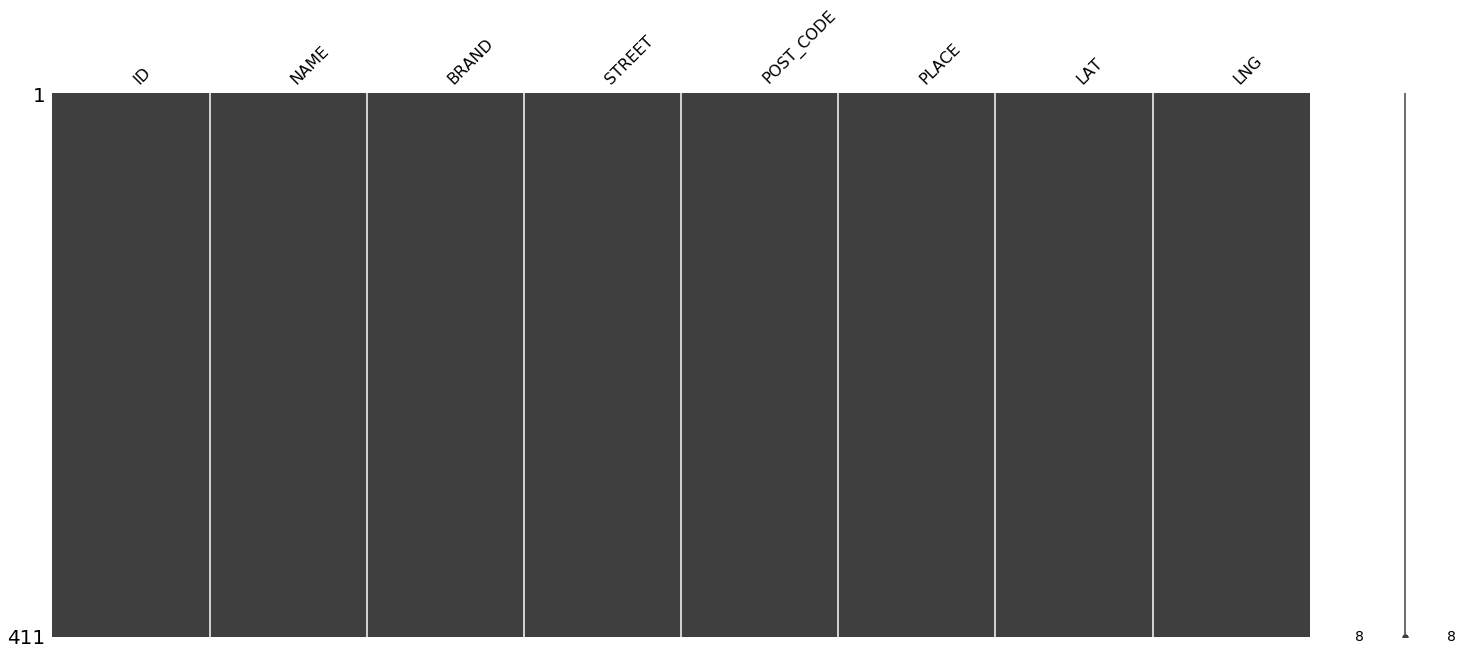

In [15]:
# Visualise number of missing entries
msno.matrix(df_stations);

# Analysis of prices: Visualise missing data and sample data

In [ ]:
df_prices = pd.read_csv('exercise_data/example_sprit_cut_prices.csv',sep=';')
# Visualise number of missing entries
msno.matrix(df_prices);

In [ ]:
df_prices.sample(10)

# Analysis of prices : Clean data
We see that there are invalid prices along with duplicates. We need to normalise the dataset firstly and then perform the analysis

In [ ]:
# Drop duplicates
df_prices.drop_duplicates(inplace=True)
msno.matrix(df_prices);

In [ ]:
e5_invalid=df_prices[df_prices['E5']<=0]
e5_invalid

In [ ]:
# Remove invalid prices from the data
def remove_invalid_prices(fuel_name):
    fuel_invalid=df_prices[df_prices[fuel_name]<=0]
    df_prices.drop(fuel_invalid.index,axis=0,inplace=True)

remove_invalid_prices('E5')
remove_invalid_prices('E10')
remove_invalid_prices('DIESEL')

In [ ]:
df_prices.describe()

We see that the max, min are quite unrealistically bad. This needs normalisation

In [ ]:
def normalise_data(fuel_name):
    data_mean, data_std = df_prices[fuel_name].mean(), df_prices[fuel_name].std()
    # identify outliers upto 3 standard deviations
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off

    df_prices[fuel_name]=np.where(np.logical_or(df_prices[fuel_name] <
                                                lower,df_prices[fuel_name] > upper), 
                                  df_prices[fuel_name].median(), 
                                  df_prices[fuel_name])

normalise_data('E5')
normalise_data('E10')
normalise_data('DIESEL')

In [ ]:
df_prices.describe()

In [ ]:
# Replace fuel prices to euro
for fuel in ('E5','E10','DIESEL'):
    df_prices[fuel] = df_prices[fuel]/1000

# Save dates in standard format
df_prices['DATE_CHANGED'] = pd.to_datetime(df_prices['DATE_CHANGED'])

# Exercise Questions and solutions

# 1. How many different stations exist in the data set and what is the existing history in days (bar chart)?

In [ ]:
df_stations.rename(columns={'ID':'STID'}, inplace=True)

In [ ]:
merged_df= pd.merge(df_prices,df_stations, on='STID')

In [ ]:
no_of_stations = merged_df.STID.nunique()
no_of_brands = merged_df.BRAND.nunique()
display(Markdown('# There are '+str(no_of_stations)+' stations belonging to '+str(no_of_brands)+' brands'))

In [ ]:
# We assume brand history in the specified data is the existing history
brand_existence = merged_df.groupby('BRAND')['DATE_CHANGED']
brand_start=brand_existence.min().reset_index()
brand_end=brand_existence.max().reset_index()
# get brand history in days and 
brand_history = (pd.to_datetime(brand_end['DATE_CHANGED'])-pd.to_datetime(brand_start['DATE_CHANGED'])).dt.days
brand_end['No of Days'] = brand_history

In [ ]:
display(Markdown('# Existing history'))
dims = (20, 5)
fig, ax = plt.subplots(figsize=dims)
g = sns.barplot(ax=ax,x='BRAND',y='No of Days',data=brand_end);
# rotate labels
plt.setp(g.get_xticklabels(), rotation=90);

# 2. What is the min, mean, max price for each gasoline type and station weekly (time series graph)?

In [ ]:
date_changed_df = merged_df.DATE_CHANGED

def plot_fuel_stats(fuel_name):
    plt.figure(figsize=(20,5))
    plt.title('Prices of '+fuel_name)
    (merged_df.groupby(date_changed_df.dt.week)[fuel_name].max()).plot(label='Max')
    (merged_df.groupby(date_changed_df.dt.week)[fuel_name].mean()).plot(label='Mean')
    (merged_df.groupby(date_changed_df.dt.week)[fuel_name].min()).plot(label='Min')
    plt.legend(loc='upper right');
    plt.xlabel('Number of weeks');
    plt.ylabel('Price in Euro');

In [ ]:
plot_fuel_stats('E5')

In [ ]:
plot_fuel_stats('E10')

In [ ]:
plot_fuel_stats('DIESEL')

# 3. What is cheapest station (in average) and why?

In [ ]:
cheap_E5=merged_df.groupby('BRAND')['E5'].min().sort_values().reset_index()
cheap_E10=merged_df.groupby('BRAND')['E10'].min().sort_values().reset_index()
cheap_DIESEL=merged_df.groupby('BRAND')['DIESEL'].min().sort_values().reset_index()

In [ ]:
x=pd.merge(cheap_E5,cheap_E10)
cheapest_stations=pd.merge(x,cheap_DIESEL)
cheapest_stations['Mean']=cheapest_stations.mean(axis=1)

avg_min_price = cheapest_stations['Mean'].min()
avg_min_price_string = str("{0:.3f}".format((avg_min_price)))+' Euro'

min_index = cheapest_stations['Mean'].idxmin()
cheapest_brand = cheapest_stations.iloc[min_index]['BRAND']

display(Markdown('# The cheapest station in average is '+cheapest_brand+' since it offers all fuels at low price'))
display(Markdown('# The average price is '+avg_min_price_string))

# 4. At which day of a week is the price most likely the cheapest (week profile)?

In [ ]:
day_grouped_obj = merged_df.groupby(merged_df.DATE_CHANGED.dt.day_name())['E5', 'E10','DIESEL'].mean()

day_grouped_obj['Mean']=day_grouped_obj.mean(axis=1)

# Reindex by day of week
day_grouped_obj = day_grouped_obj.groupby(['DATE_CHANGED']).sum().reindex(day_name[0:7]) 

plt.figure(figsize=(20,5))
plt.title('Week Profile')

min_index = day_grouped_obj['Mean'].idxmin()
plt.plot(day_name[0:7], day_grouped_obj['Mean'])

plt.xlabel('Day of the week');
plt.ylabel('Mean Fuel Price in Euro');

display(Markdown('# The cheapest price will be most likely on '+min_index))

# 5. At which hour during a day is the price the cheapest in average (hour profile)?

In [ ]:
hour_grouped_obj = merged_df.groupby(merged_df.DATE_CHANGED.dt.hour)['E5', 'E10','DIESEL'].mean()

hour_grouped_obj['Mean']=hour_grouped_obj.mean(axis=1)

plt.figure(figsize=(20,5))
plt.title('Hour Profile')

min_index = hour_grouped_obj['Mean'].idxmin()
(hour_grouped_obj['Mean']).plot();

display(Markdown('# The cheapest price will be most likely at '+str(min_index)+' Hours'))

# 6. How many different station locations are present in the data (visualize via a map)?

In [ ]:
tile_provider = get_provider(Vendors.CARTODBPOSITRON)

# South west of Germany bounds in web mercator coordinates
p = figure(x_range=(818793.446991, 1010373.869043), y_range=(6387689.579736,6282024.377476),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)
                         
#coords_df.head()
merc_coords = []
for x,y in set(zip( df_stations['LAT'].tolist(),df_stations['LNG'].tolist())):
    merc_coords.append((transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), y, x))) # longitude first, latitude second.
lats = [x for (x,y) in merc_coords]
longs = [y for (x,y) in merc_coords]
p.circle(x = lats,
         y = longs,line_color="red", 
         fill_color="orange",
         fill_alpha=0.5)
#show(p)
html = file_html(p, CDN, "my plot")
display(HTML(html))
#output_notebook()
display(Markdown('# There are '+str(len(merc_coords))+' different station locations'))

# 7. What is the gas station which has most price data points, choose one and draw the time series for all 3 gasoline types?

In [ ]:
brand_price=merged_df[['BRAND','E5','E10','DIESEL','DATE_CHANGED']]

In [ ]:
brand_data_points=brand_price.BRAND.value_counts()
brand_most_stations = brand_data_points.idxmax()

In [ ]:
most_brands_df= brand_price[brand_price['BRAND']==brand_most_stations]
display(Markdown('# The gas station which has most price data points is '+brand_most_stations))

In [ ]:
plt.figure(figsize=(20,5))
plt.title('Weekly Profile of '+brand_most_stations)
most_brands_df.groupby(most_brands_df.DATE_CHANGED.dt.week).E5.mean().plot(xticks=range(1,53))
most_brands_df.groupby(most_brands_df.DATE_CHANGED.dt.week).E10.mean().plot(xticks=range(1,53))
most_brands_df.groupby(most_brands_df.DATE_CHANGED.dt.week).DIESEL.mean().plot(xticks=range(1,53))
plt.legend(loc='upper right')
plt.xlabel('Number of weeks')
plt.ylabel('Price in Euros');

# 8. At which hour during a day do we have the most price changes?

In [ ]:
e5_changes = (brand_price.groupby(brand_price.DATE_CHANGED.dt.hour))['E5', 'E10','DIESEL'].count()
e5_changes.plot(figsize=(20,5));

In [ ]:
max_index = e5_changes.E5.idxmax()
max_num_changes = e5_changes.E5.max().mean()
display(Markdown('# The hour during the day we have the most price changes is at '+str(max_index)+' Hours with '+str(int(max_num_changes))+' changes'));

# 9. Select 20 gas stations having the longest time history and visualize the average price per month. Use heatmap and only the prices between 12:00-13:00 of e10 and diesel

In [ ]:
brand_group = brand_end.groupby('No of Days')

In [ ]:
max_idx = brand_group['BRAND'].count().idxmax()

In [ ]:
top_brand_list = (brand_group.get_group(max_idx)['BRAND'][:20]).to_list()
top_brand_list

In [ ]:
month_grouped_obj = merged_df.groupby(merged_df.DATE_CHANGED.dt.month_name())['E10','DIESEL'].mean()

In [ ]:
month_grouped_obj['Mean']=month_grouped_obj.mean(axis=1)
hour_grouped_obj = merged_df.groupby(merged_df.DATE_CHANGED.dt.hour)['E10','DIESEL'].mean()
hour_grouped_obj

In [ ]:
for brand in top_brand_list:
    merged_df_brand = merged_df[merged_df['BRAND']==brand]
    month_data = merged_df_brand.groupby(merged_df_brand.DATE_CHANGED.dt.month_name())['E10','DIESEL'].mean()

In [ ]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
sns.heatmap(month_data, cbar_kws={'format': '%1.2f Euro'}, yticklabels=months);

# 10. Describe a possible business potential in € for the customer . Define the constraints of the business case 5 lines, the answer max 15 lines (high level summary)

* The cheapest station in average is Hem. So, prefer this brand for refuelling.
* The cheapest price will be most likely on Saturday.Refuel accordingly. 
* The cheapest price will be most likely at 18 Hours. So, refuelling at this time is good
* Price is influenced by the hour a lot. So, when to refuel must mainly be based on hour
* Using cheapest station can save upto 20 cents every time we refuel. So, there is a lot of saving potential